# Image Classification on oxford_flowers102 dataset (84% - accuracy)
## Steps
- import modules
- download dataset
- explore the dataset
- create the dataset pipeline 
- build  mobilenet_v2 feature extractor 
- build data augmentation
- build classification head
- build th final model 
- compile the final model 
- write callbacks 
- train the final model 
- plot the training curve
- load and evaluate the final model 
- write inference functions(to process and predict an image)
- get inference images 
- run inference 





In [9]:
## necessary imports 

import tensorflow as tf 
import tensorflow_datasets as tfds 
from tensorflow import keras 
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow_hub as hub
from tensorflow_hub import KerasLayer
from PIL import Image

In [10]:
IMG_RES = 224
BATCH_SIZE = 32

In [11]:
## load the data 
(training_data, test_data , validation_data), data_infos = tfds.load('oxford_flowers102',split=['test', 'train','validation'],
                                                shuffle_files=True,
                                                as_supervised= True,
                                                with_info=True,)

In [4]:
## explore the dataset

In [4]:
print("Total number of training samples :", len(training_data))
print("Total number of test samples :", len(test_data))
print("Total number of validation samples :", len(validation_data))

num_classes = data_infos.features['label'].num_classes
print("Total number of classes  :", num_classes)


Total number of training samples : 6149
Total number of test samples : 1020
Total number of validation samples : 1020
Total number of classes  : 102


In [5]:
for i , sample in enumerate(training_data.take(3)):
  print("Image {} shape {} label {}".format(i+1, sample[0].shape, sample[1]))

Image 1 shape (500, 667, 3) label 95
Image 2 shape (500, 752, 3) label 72
Image 3 shape (500, 576, 3) label 49


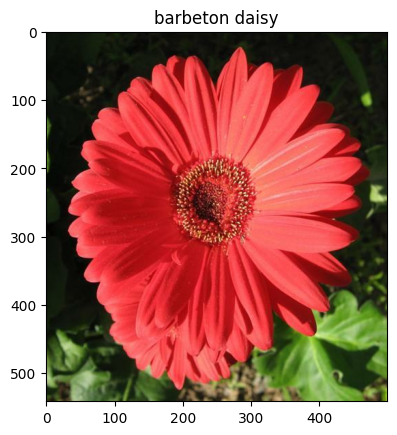

In [6]:
get_label_name = data_infos.features['label'].int2str 

for image, label in training_data.take(1):
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.show()

In [7]:
## create pipeline
def normalize_img(image, label, img_size=IMG_RES):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (img_size, img_size))
    return tf.cast(image, tf.float32) / 255., label 

def build_dataset(dataset, infos = data_infos, which='train', batch_size = BATCH_SIZE):
    dataset = dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
    if which == 'test':
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(1)
        return dataset
    dataset = dataset.cache()
    if which == 'train':
      dataset = dataset.shuffle(len(training_data)//4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

In [8]:
train_ds = build_dataset(training_data, which='train')
validation_ds = build_dataset(validation_data, which='validation')
test_ds = build_dataset(test_data, which='test')

In [9]:
## build and train the classifier

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_RES, IMG_RES, 3))

feature_extractor.trainable = False

In [10]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])


In [21]:
## classification head 

classifier = keras.Sequential([
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
], name="head_classifier")

In [22]:
inputs = keras.Input(shape=(IMG_RES, IMG_RES, 3))
x = data_augmentation(inputs)
x = feature_extractor(x, training=False)
outputs = classifier(x)

model = keras.Model(inputs , outputs , name="mobilenet_v2_keras")

In [23]:
base_learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate= base_learning_rate)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer = optimizer,
              loss= loss , 
              metrics = ["accuracy"]    
)

model.summary()

Model: "mobilenet_v2_keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 head_classifier (Sequential  (None, 102)              1416294   
 )                                                               
                                                                 
Total params: 3,674,278
Trainable params: 1,416,294
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath = "{}.keras".format(model.name),
    save_best_only = True
)

EarlyStopping = keras.callbacks.EarlyStopping(
    patience = 5,
    restore_best_weights = True
)

In [25]:
initial_epoch = 20
loss0 , accuracy0 = model.evaluate(validation_ds)

print("Initial Loss : {}".format(loss0))   
print("Initial Accuracy : {}".format(accuracy0))

32/32 [==============================] - 2s 42ms/step - loss: 4.8402 - accuracy: 0.0078
Initial Loss : 4.8401665687561035
Initial Accuracy : 0.007843137718737125


In [26]:
tf.keras.backend.clear_session()
history = model.fit( train_ds,
                    validation_data = validation_ds ,
                    epochs = initial_epoch+20 ,
                    callbacks = [ModelCheckpoint, EarlyStopping])

Epoch 1/40
193/193 [==============================] - 14s 59ms/step - loss: 3.6586 - accuracy: 0.2231 - val_loss: 3.2289 - val_accuracy: 0.2686
Epoch 2/40
193/193 [==============================] - 11s 57ms/step - loss: 2.2073 - accuracy: 0.5012 - val_loss: 2.1860 - val_accuracy: 0.4990
Epoch 3/40
193/193 [==============================] - 12s 62ms/step - loss: 1.5829 - accuracy: 0.6180 - val_loss: 1.6183 - val_accuracy: 0.6353
Epoch 4/40
193/193 [==============================] - 11s 57ms/step - loss: 1.2456 - accuracy: 0.6868 - val_loss: 1.3378 - val_accuracy: 0.6892
Epoch 5/40
193/193 [==============================] - 11s 56ms/step - loss: 1.0692 - accuracy: 0.7289 - val_loss: 1.1439 - val_accuracy: 0.7373
Epoch 6/40
193/193 [==============================] - 11s 57ms/step - loss: 0.9126 - accuracy: 0.7678 - val_loss: 0.9936 - val_accuracy: 0.7667
Epoch 7/40
193/193 [==============================] - 11s 57ms/step - loss: 0.8177 - accuracy: 0.7933 - val_loss: 0.9371 - val_accuracy:

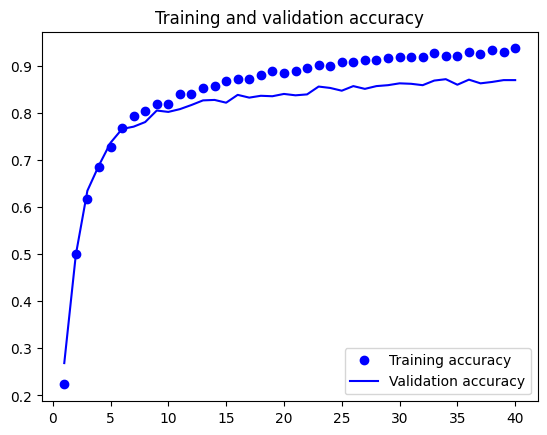

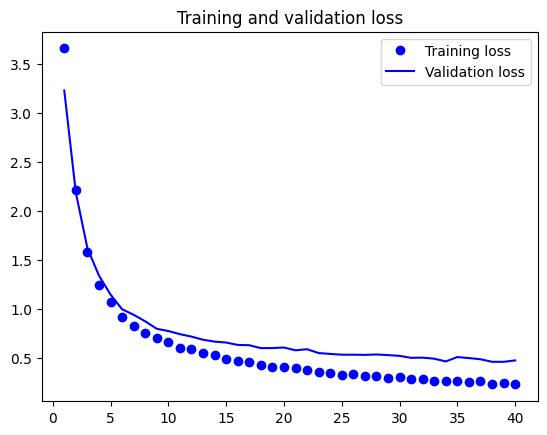

In [28]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
path = "{}.keras".format(model.name)
model = keras.models.load_model(path,  custom_objects={'KerasLayer': hub.KerasLayer})
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

In [12]:
model = keras.models.load_model("/content/mobilenet_v2_keras.keras",  custom_objects={'KerasLayer': hub.KerasLayer})


In [13]:
## inference
def process_image(img, img_res=224):
  image = np.squeeze(img)     
  image = tf.image.resize(image , (img_res,img_res))/255.0
  return image

In [14]:
get_label_name = data_infos.features['label'].int2str 


In [15]:
def predict(model , img_path, top_k=3):
  img = Image.open(img_path) 
  img = np.asarray(img)
  processed_img = process_image(img)
  
  prediction = model.predict(np.expand_dims(processed_img, axis=0))  
  top_values , top_indices = tf.math.top_k(prediction, top_k)

  print("Probability Scores :", top_values.numpy()[0])
  top_classes = [get_label_name(value) for value in top_indices.numpy()[0]]

  print("Corresponding Classes :", top_classes)
  return top_values.numpy()[0], top_classes

In [16]:
# get inference images 
! wget -O oxford_102_inference_images.zip https://drive.google.com/uc\?export\=download\&id\=1Dno9pT3uA_kbpIyHYYl_1AWIrROJ7WHv
! unzip oxford_102_inference_images.zip  


--2023-04-12 16:15:44--  https://drive.google.com/uc?export=download&id=1Dno9pT3uA_kbpIyHYYl_1AWIrROJ7WHv
Resolving drive.google.com (drive.google.com)... 74.125.201.102, 74.125.201.101, 74.125.201.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.201.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hvpv8f16jin13od7jaivb1oqt3p61fu7/1681316100000/12204303463414581294/*/1Dno9pT3uA_kbpIyHYYl_1AWIrROJ7WHv?e=download&uuid=0b15f3fe-c2da-4837-a2e5-fec5fc039daf [following]
--2023-04-12 16:15:44--  https://doc-0g-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hvpv8f16jin13od7jaivb1oqt3p61fu7/1681316100000/12204303463414581294/*/1Dno9pT3uA_kbpIyHYYl_1AWIrROJ7WHv?e=download&uuid=0b15f3fe-c2da-4837-a2e5-fec5fc039daf
Resolving doc-0g-b8-docs.googleusercontent.com (doc-0g-b8-docs.googleusercontent.com)... 74.125.132.132, 2607:

1/1 [==============================] - 1s 822ms/step
Probability Scores : [0.71658313 0.10534659 0.03617592]
Corresponding Classes : ['petunia', 'artichoke', 'sweet william']


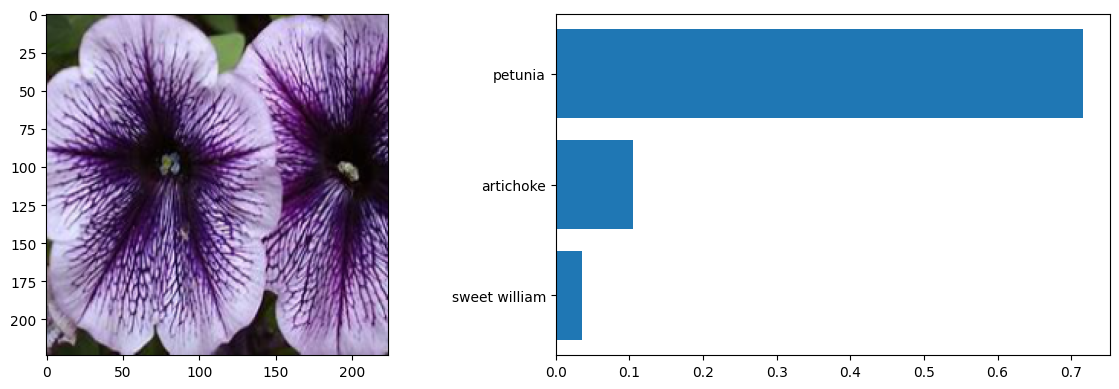

1/1 [==============================] - 0s 73ms/step
Probability Scores : [9.9961048e-01 2.6128659e-04 2.6834807e-05]
Corresponding Classes : ['passion flower', 'pincushion flower', 'love in the mist']


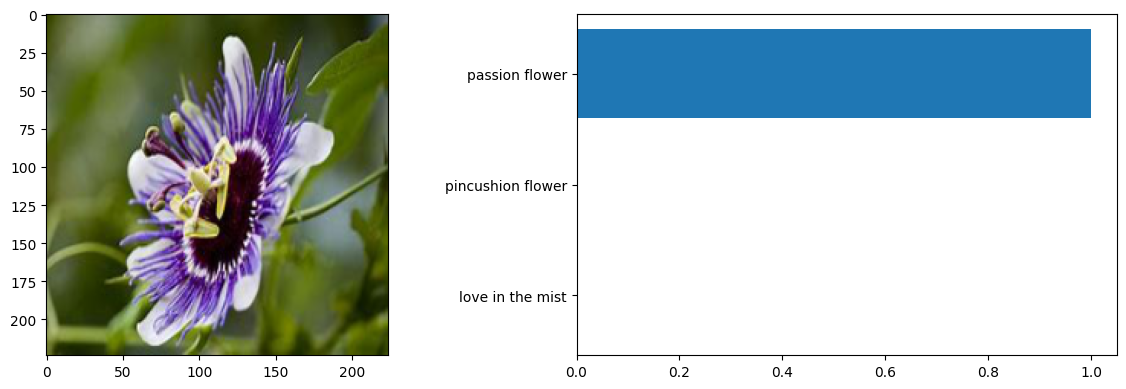

1/1 [==============================] - 0s 68ms/step
Probability Scores : [0.6381997  0.11737476 0.09411833]
Corresponding Classes : ['mallow', 'rose', 'lotus']


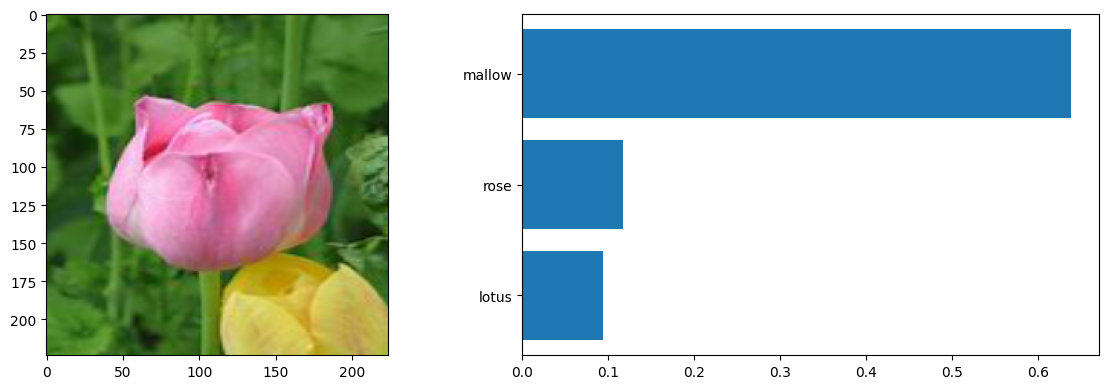

1/1 [==============================] - 0s 95ms/step
Probability Scores : [0.97551686 0.0143422  0.00394544]
Corresponding Classes : ['lotus', 'water lily', 'siam tulip']


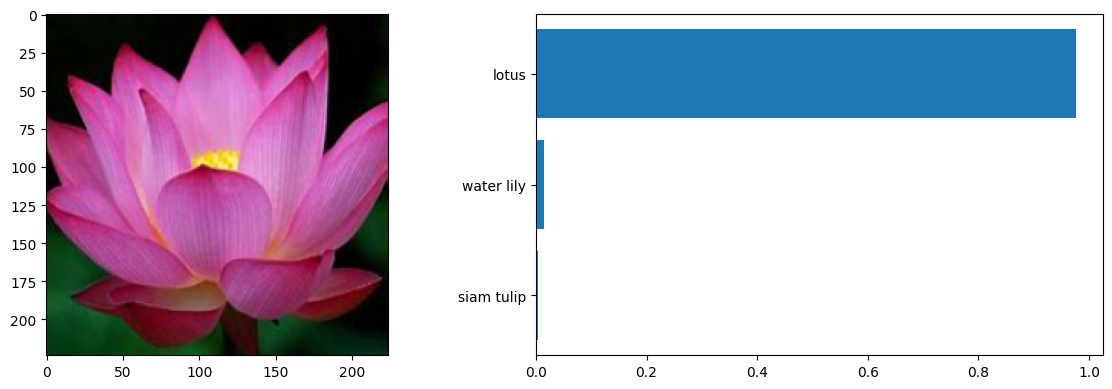

In [17]:
import glob
files = glob.glob('/content/oxford_102_inference_images/*.jpeg')

for image_path in files :
  img = Image.open(image_path)                
  img = np.asarray(img)
  processed_img = process_image(img)
  probs , classes = predict(model , image_path)
  fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
  ax1.imshow(processed_img)
  ax2 = plt.barh(classes[::-1], probs[::-1])
  plt.tight_layout()
  plt.show()